In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import dataset, dataloader
import torch.nn.functional as F
import pandas as pd
import nltk
import os
import glovar
import collections
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Skip-Gram Implementation Practice

Your goal is to implement the Skip-Gram model in PyTorch, including pre-processing. 

Pre-processing is an important step in deep learning with text, and you should learn it now. Even though the Skip-Gram model is different from tasks such as sentence classification, these pre-processing skills are relevant to working with text in general. 

This tutorial assumes you are familiar with the basics of PyTorch. If not, you should only need review this tutorial first:

https://github.com/jcjohnson/pytorch-examples

Stages in this tutorial:
1. Load the Data
2. Tokenize the Data
3. Build the Vocab Dictionary
4. Prepare Training Pairs
5. Implement Negative Sampling
6. Prepare Data for the Network
7. Code the Model
8. Train the Model
9. Visualize the Embeddings

Tips are provided for the pre-processing stage to make it smoother. Try not to use them. If you have to, put aside some time to learn those skills properly.

You will see validation cells along the way with `assert` calls. Run these to make sure you haven't made any mistakes along the way that will prevent you from proceeding. You will need to do the steps in order.

## 1. Load the Data

We will use the data from SemEval18 Task 12, the Argument Reasoning Comprehension Task (https://github.com/habernal/semeval2018-task12).

The data comes in csv format so we will use pandas to load the data. If you don't know pandas, you should get to know it right away because it is extremely useful.

In [2]:
train_path = os.path.join(glovar.DATA_DIR, 'train-full.txt')
dev_path = os.path.join(glovar.DATA_DIR, 'dev-full.txt')
test_path = os.path.join(glovar.DATA_DIR, 'test-only-data.txt')
test_labels_path = os.path.join(glovar.DATA_DIR, 'test-labels.txt')

In [3]:
train = pd.read_csv(train_path, delimiter='\t')
dev = pd.read_csv(dev_path, delimiter='\t')
test = pd.read_csv(test_path, delimiter='\t')
test_labels = pd.read_csv(test_labels_path, delimiter='\t', header=None)
test_labels.columns = ['#id', 'correctLabelW0orW1']
test = pd.concat([test, test_labels])

## 2. Tokenization

We need to determine the set of all tokens in our dataset. We therefore need to separate each comment string into individual tokens, then determine the unique set of those tokens. We focus on the tokenization step first.

We will use `nltk` for tokenization because it is lightweight. The `nltk` package defines a function called `word_tokenize()` that is useful for this.

In [4]:
text_columns = ['claim', 'reason', 'debateInfo', 'debateTitle', 'warrant0', 'warrant1']
sents = []
for column in text_columns:
    sents += list(train[column].values)
    sents += list(dev[column].values)
    sents += list(test[column].values)
# Some values are nan - remove those
sents = [s for s in sents if not pd.isnull(s)]

In [5]:
token_set = set([])
for sent in sents:
    token_set.update(nltk.word_tokenize(sent))

In [6]:
assert len(token_set) == 6116

## 3. Build the Vocab Dictionary

We need to associate a unique `int` index with every unique token, and provide a map for lookup. A high-level view of text processing is often: 
1. receive text as input
2. tokenize that text to obtain tokens
3. map those tokens to integer indices
4. use those indices to lookup word vectors
5. use those vectors as input to a neural network.

We focus on (3) now.

### To Do
Use the `token_set` to build a `dict` object called `vocab` that has every unique token in the `token_set` as an index and unique integers as `values`. Also add a token `'<PAD>'` to the vocab. We will need it when we deal with recurrent neural networks.

Tips:
- The python `zip()` function can be used to bring two lists together - e.g. tokens and indices
- The `dict()` constructor can take a zipped object as input, mapping the first position to index and second to value

In [7]:
# vocab = ???
vocab = dict(zip(['<PAD>'] + list(token_set), 
                 range(len(token_set) + 1)))

In [8]:
assert len(vocab) == 6117
assert isinstance(list(vocab.keys())[0], str)
assert isinstance(list(vocab.values())[0], int)
assert '<PAD>' in vocab.keys()

We will also define a reverse lookup dictionary (integer indexes as keys and string tokens as values) for later use.

In [9]:
rev_vocab = {v: k for k, v in vocab.items()}

## 4. Prepare the Training Pairs

We need to present two words at a time to the network to train our Skip-Gram: a center word and a context word. We therefore need to determine these pairs beforehand.

Before coding deep learning models it is necessary to first fully think through how we are going to present the data to the network. This will avoid having to make annoying changes that might follow from small details that are easy to overlook.

We know we are going to present two words at a time: a center word, and a context word. But how are we going to present them: as tokens, or as indices? These details matter when you code the forward pass of the network: if you try a word vector lookup on an embedding matrix with a string, you will see an error. We will use integer indices as it will be slightly faster than adding a dictionary lookup as well at training time.

Since finding the context tokens for all words over all instances in the dataset is not a generally useful skill, we do that for you.

In [10]:
m = 5  # our context window size - you can experiment with this
contexts = {k: set() for k in range(1, len(vocab) + 1)}
for sent in sents:
    tokens = nltk.word_tokenize(sent)
    for i, center in enumerate(tokens):
        center = vocab[center]
        left_context = [vocab[t] for t in tokens[max(0, i - m):i - 1]]
        right_context = [vocab[t] for t in tokens[i + 1: min(len(tokens), i + m)]]
        contexts[center].update(left_context + right_context)

The `contexts` variable is a dictionary where the keys are the indices of all the tokens in the dataset, and the values are `set`s of token indices that occur in their contexts. We will sample from these during training.

Finally, we need the frequencies of our words for the negative sampling algorithm.

### To Do

Use the training data and `nltk.word_tokenize` to create a `collections.Counter` object that holds each unique token as a key, and the frequency count as a value.

Tips:
- `Counter` has an `update()` function that can accept lists of key values (i.e. tokens) and automatically does the counting for you

In [11]:
# frequencies = ???
frequencies = collections.Counter()
for sent in sents:
    tokens = nltk.word_tokenize(sent)
    frequencies.update(tokens)

In [12]:
assert len(frequencies) == len(vocab) - 1  # we don't see <PAD> in the data
assert isinstance(list(frequencies.keys())[0], str)
assert isinstance(list(frequencies.values())[0], int)

In [13]:
# We'll add <PAD> to the frequencies to even the lengths of the probability distributions for later
frequencies['<PAD>'] = 0

The last thing we need to prepare our data for training is define it as a set of pairs of words. Making a complete pass over this set constitutes one epoch of the data.

In [14]:
pairs = set([])
for center in contexts.keys():
    pairs.update(tuple(zip([center] * len(contexts[center]), list(contexts[center]))))
data = list(pairs)
print('Number of pairs in the dataset: %s' % len(data))

Number of pairs in the dataset: 182776


## 5. Negative Sampling

To perform negative sampling, we need a function that
- Takes a token index as argument
- Returns the number of negative samples we desire
- Randomly chooses those samples according to

$$
P(w_i) = \frac{f(w_i)^{3/4}}{\sum_{j=0}^n (f(w_j)^{3/4})}
$$

We will define this function as a callable class, since it depends on state information (the `vocab`, `frequencies`, and `contexts`).

In [15]:
class NegativeSampler:
    
    def __init__(self, vocab, frequencies, contexts, num_negs):
        """Create a new NegativeSampler.
        
        Args:
          vocab: Dictionary.
          frequencies: List of integers, the frequencies of each word,
            sorted in word index order.
          contexts: Dictionary.
          num_negs: Integer, how many to negatives to sample.
        """
        self.vocab = vocab
        self.n = len(vocab)
        self.contexts = contexts
        self.num_negs = num_negs
        self.distribution = self.p(list(frequencies.values()))
    
    def __call__(self, tok_ix):
        """Get negative samples.
        
        Args:
          tok_ix: Integer, the index of the center word.
        
        Returns:
          List of integers.
        """
        neg_samples = np.random.choice(
            self.n, 
            size=self.num_negs, 
            p=self.distribution)
        # make sure we haven't sampled center word or its context
        invalid = [-1, tok_ix] + list(self.contexts[tok_ix])
        for i, ix in enumerate(neg_samples):
            if ix in invalid:
                new_ix = -1
                while new_ix in invalid:
                    new_ix = np.random.choice(self.n, 
                                              size=1, 
                                              p=self.distribution)[0]
                neg_samples[i] = new_ix
        return [int(s) for s in neg_samples]
    
    def p(self, freqs):
        """Determine the probability distribution for negative sampling.
        
        Args:
          freqs: List of integers.
        
        Returns:
          numpy.ndarray.
        """
        ### Impelement Me ###
        freqs = np.array(freqs)
        return np.power(freqs, 3/4) / np.sum(np.power(freqs, 3/4))

## 6. Prepare Data for the Network

Whatever kind of data we pass our neural network, we often need to take some pre-processing steps at training and prediction time. In our case, we need to perform negative sampling and prepare whatever data structure we decide to pass to our network.

What is in a batch of data?
- center word
- context word
- negative samples

How will we use it?
- embedding lookup for all words
- dot product of center word with context word and negative samples
- softmax over the resulting values

We must define our target vector for the cross-entropy loss calculation. Without negative sampling this is a probability distribution over the entire vocabulary with a `1` at the index of the context word. With negative sampling, we only want to calculate loss and backpropagate gradient for the words in each pass: context, negative samples. We can decide how to arrange this. A consistent convention will be convenient. With five negative samples, we will put the context word in the first position, so all our "targets" will look like:

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

We show a row vector here, but in practice this will be a 1D `Tensor`.

It will also be convenient to perform all our dot products in parallel. Efficient neural net implementations avoid for loops wherever possible. We can parallelize our implementation by stacking the output embeddings into a matrix and performing a matrix multiplication with the input vector.

### To Do

Define a `collate(pairs)` function that accepts a `list` of `tuple`s and returns an appropriate data structure, given the considerations just discussed. The tuples will all look like `(center, context)` - i.e. a pair in our `data` variable. The collate function will need to perform negative sampling. It will therefore depend on a NegativeSampler, so we should wrap it and make it a callable.

This might be a challenge and you will need to think forward to how to perform the embedding lookup and matrix multiplication.

Note: normally we would need to collate labels for training, but since we have a conventional target we don't need to here.

In [16]:
class Collate:
    
    def __init__(self, neg_sampler):
        self.sampler = neg_sampler
    
    def __call__(self, pairs):
        ### Implement Me ###
        batch_size = len(pairs)
        centers = [x[0] for x in pairs]
        contexts = [x[1] for x in pairs]
        context_and_negs = []
        for i in range(batch_size):
            neg_samples = self.sampler(centers[i])
            context_and_negs.append([contexts[i]] + list(neg_samples))
        return centers, context_and_negs

Finally, we will want to create a `DataLoader` with our collate function. This will take care of some nice things for us: 
- shuffling our training pairs each epoch
- facilitating enumeration of batches for training
- applying our collate function to each batch
- parallelizing this work on the CPU whilst our GPU processes our model

In [17]:
def get_data_loader(data, batch_size, collate_fn):
    return dataloader.DataLoader(data, 
                                 batch_size=batch_size, 
                                 shuffle=True, 
                                 num_workers=1, 
                                 collate_fn=collate_fn)

## 7. Code the Model

For each training pair, we need to:
1. Perform embedding lookup for the center word (from $\mathbf{V}$)
2. Lookup the context and negative sample embeddings (from $\mathbf{U}$)
3. Perform a dot product of the center word embeddings with context and negative sample embeddings
4. Pass the results of the dot products to the softmax function
5. Compute the loss given the labels
6. Use the loss to update the vectors

Remember that softmax is defined as

$$
\text{softmax}(\mathbf{x})_i =
\frac
{e^{x_i}}
{\sum_j e^{x_j}}
$$

And cross-entropy is

$$
\text{CE}(\hat{\mathbf{y}}, \mathbf{y}) = - \sum_i y_i \log(\hat{y}_i) \\
$$

As an implementation note for softmax, for numerical stability we subtract the maximum value from the input vector to softmax. The following proof shows that softmax is invariant to such a change

$$
\begin{align}
\text{softmax}(\mathbf{x} + c)_i & = \frac{e^{x_i + c}}{\sum_j e^{x_j + c}} \\
& = \frac
{e^c e^{x_i + c}}
{e^c \sum_j e^{x_j}} \\
& = \frac
{e^{x_i}}
{\sum_j e^{x_j}} \\
& = \text{softmax}(\mathbf{x})_i
\end{align}
$$

In practice you will usually just use the PyTorch implementation of the function. But understanding the deeper mathematical details will take you further in your research. Issues of numerical stability are particularly important in deep learning.

Below is a template for the model. We will walk through the steps here. Look for `### Implement Me ###` in the model template for the parts you need to complete.

In [ ]:
class SkipGram(nn.Module):
    """SkipGram Model."""
    
    def __init__(self, vocab, emb_dim, num_negs, lr):
        """Create a new SkipGram.
        
        Args:
          vocab: Dictionary, our vocab dict with token keys and index values.
          emb_dim: Integer, the size of word embeddings.
          num_negs: Integer, the number of non-context words to sample.
          lr: Float, the learning rate for gradient descent.
        """
        super(SkipGram, self).__init__()
        self.vocab = vocab
        self.n = len(vocab)  # size of the vocab
        self.emb_dim = emb_dim
        self.num_negs = num_negs
        
        ### Implement Me: define V and U ###
        
        ### Implement Me: initialize V and U with unform distribution in [-0.01, 0.01] ###
        
        self.V = nn.Embedding(self.n, emb_dim)
        self.U = nn.Embedding(self.n, emb_dim)
        #self.V = nn.Parameter(torch.Tensor(self.n, emb_dim), requires_grad=True)
        #self.U = nn.Parameter(torch.Tensor(emb_dim, self.n), requires_grad=True)
        nn.init.uniform(self.V.weight, a=-0.01, b=0.01)
        nn.init.uniform(self.U.weight, a=-0.01, b=0.01)        
        
        # Adam is a good optimizer and will converge faster than SGD
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        self.criterion = torch.nn.CrossEntropyLoss()
        
        if torch.cuda.is_available():
            self.cuda()
    
    def forward(self, batch):
        """Compute the forward pass of the network.
        
        1. Lookup embeddings for center and context words
            - use self.lookup()
        2. Sample negative samples
            - use self.negative_samples()
        2. Calculate the probability estimates
            - make sure to implement and use self.softmax()
        3. Calculate the loss
            - using self.loss()
        
        Args:
          batch: whatever data structure you decided to make for a batch.
        
        Returns:
          loss (torch.autograd.Variable).
        """
        ### Implement Me: lookup center words ###
        ### Implement Me: lookup context words ###
        ### Implement Me: lookup negative words ###
        cents, conts_negs = batch
        cents = self.V(self.lookup_tensor(cents)).unsqueeze(1)
        conts_negs = self.U(self.lookup_tensor(conts_negs)).permute([0, 2, 1])
        logits = cents.matmul(conts_negs).squeeze(1)
        targets = self.targets(cents.shape[0])
        return self.criterion(logits, targets)
        preds = self.softmax(logits)        
        return self.loss(preds, targets)
    
    def lookup_tensor(self, indices):
        """Lookup embeddings given indices.
        
        Args:
          embedding: nn.Parameter, an embedding matrix.
          indices: List of integers, the indices to lookup.
        
        Returns:
          torch.autograd.Variable of shape [len(indices), emb_dim]. A matrix 
            with horizontally stacked word vectors.
        """
        if torch.cuda.is_available():
            return Variable(torch.LongTensor(indices),
                            requires_grad=False).cuda()
        else:
            return Variable(torch.LongTensor(indices),
                            requires_grad=False)
    
    def loss(self, preds, targets):
        """Compute cross-entropy loss.
        
        Implement this for practice, don't use the built-in PyTorch function.
        
        Args:
          preds: Tensor of shape [batch_size, vocab_size], our predictions.
          targets: List of integers, the vocab indices of target context words.
        """
        ### Implement Me ###
        return -1 * torch.sum(targets * torch.log(preds))
    
    def optimize(self, loss):
        """Optimization step.
        
        Args:
          loss: Scalar.
        """
        # Remove any previous gradient from our tensors before calculating again.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()        
    
    def softmax(self, logits):
        """Compute the softmax function.
        
        Implement this for practice, don't use the built-in PyTorch function.
        
        Args:
          logits: Tensor of shape [batch_size, vocab_size].
        
        Returns:
          Tensor of shape [batch_size, vocab_size], our predictions.
        """
        ### Impelement Me ###
        return torch.exp(logits) / torch.sum(torch.exp(logits))
    
    def targets(self, batch_size):
        """Get the conventional targets for the batch.
        
        Args:
          batch_size: Integer.
        
        Returns:
          torch.LongTensor.
        """
        return Variable(torch.zeros((batch_size,)).long(), requires_grad=False)
        #targets = torch.zeros((batch_size, self.num_negs + 1))
        #targets[:, 0] = 1
        #return Variable(targets, requires_grad=False)

## 8. Train the Model

Training algorithms should consider
- Learning rate annealing
- Convergence conditions
- Early stopping

Here we will not anneal the learning rate for simplicity and pre-define a 10 epoch limit. Training will stop early if loss doesn't improve after one epoch.

You should experiment with different training strategies in your own work.

In [ ]:
# Hyperparameters
max_epochs = 5
emb_dim = 30
num_negs = 10
lr = 0.01
batch_size = 1

sampler = NegativeSampler(vocab, frequencies, contexts, num_negs)
collate = Collate(sampler)
data_loader = get_data_loader(list(pairs), batch_size, collate)
model = SkipGram(vocab, emb_dim, num_negs, lr)
if torch.cuda.is_available():
    model.cuda()

epoch = 0
global_step = 0
cum_loss = 0.
while epoch < max_epochs:
    epoch += 1
    print('Epoch %s' % epoch)
    for step, batch in enumerate(data_loader):
        global_step  += 1
        loss = model.forward(batch)
        model.optimize(loss)
        loss = loss.data.cpu().numpy()[0]
        cum_loss += loss
        if step % 1000 == 0:
            print('Step %s\t\tLoss %8.4f' % (step, cum_loss / (global_step * batch_size)))

V.weight:	torch.Size([6117, 30])
U.weight:	torch.Size([6117, 30])
Epoch 1
Step 0		Loss   2.3980
Step 1000		Loss   2.3481
Step 2000		Loss   2.2496
Step 3000		Loss   2.1707
Step 4000		Loss   2.1086
Step 5000		Loss   2.0748
Step 6000		Loss   2.0471
Step 7000		Loss   2.0159
Step 8000		Loss   2.0052


## 9. Visualize Embeddings



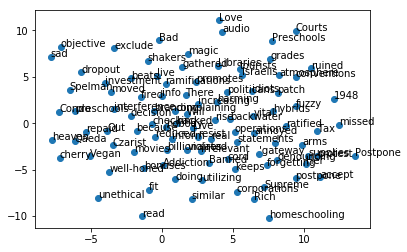

In [56]:
random_ixs = torch.from_numpy(np.random.choice(range(len(vocab)), 100)).long()
embeddings = model.V.weight[random_ixs].data.cpu().numpy()
tok_ixs = {k: v for k, v in vocab.items() if v in random_ixs}
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embeddings)
df = pd.DataFrame(X_tsne, index=tok_ixs, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()

What about linear regularities? Let's check some words in the dataset...

In [ ]:
# ?

## 10. Put Vectors to Use

We will now use our vectors for the ARCT task.